In [1]:
import os
import cv2
import json
import pandas as pd

from torch.utils import data


# FreiHAND

In [25]:
import json
import os
from torch.utils import data


class FreiHAND(data.Dataset):
    
    def __init__(self, path: str):
        
        super().__init__()
        
        train_path = os.path.join(path, "FreiHAND_pub_v2")
        # val_path = os.path.join(path, "FreiHAND_pub_v2_eval")
        
        self.rgb_image_path = os.path.join(train_path, "training", "rgb")
        self.mask_image_path = os.path.join(train_path, "training", "mask")
        
        with open(os.path.join(train_path, "training_scale.json")) as f:
            self.scale = json.load(f)
        with open(os.path.join(train_path, "training_mano.json")) as f:
            self.mano = json.load(f)
        with open(os.path.join(train_path, "training_xyz.json")) as f:
            self.xyz = json.load(f)

freihand_dataset = FreiHAND(
    path = "\\\\192.168.2.206\\data\\datasets\\FreiHAND"
)

In [34]:
freihand_dataset.mano[0]

[[0.721924364566803,
  0.6972370147705078,
  -0.7899668216705322,
  -0.005629386752843857,
  -0.020847106352448463,
  -0.25697168707847595,
  0.019605889916419983,
  0.020119965076446533,
  -0.752727746963501,
  0.016962876543402672,
  -0.16247829794883728,
  -0.47104501724243164,
  0.2712077796459198,
  0.07267540693283081,
  -0.38628798723220825,
  -0.0600123330950737,
  -0.04881877079606056,
  -0.7962555289268494,
  0.037846919149160385,
  -0.04672650247812271,
  -0.49364858865737915,
  0.5203770399093628,
  0.0690668448805809,
  -0.5552831292152405,
  0.21080641448497772,
  -0.20642486214637756,
  -0.3631074130535126,
  0.3601369559764862,
  -0.027657518163323402,
  -0.5777040719985962,
  0.28868335485458374,
  0.05730121210217476,
  -0.4341995418071747,
  0.1606927365064621,
  -0.2036343216896057,
  -0.8283606767654419,
  0.13506746292114258,
  0.09893530607223511,
  -0.45706236362457275,
  -0.007289777975529432,
  -0.26253533363342285,
  -0.17645134031772614,
  0.0799409225583076

# WIDER Face Face Detection

In [14]:
from motion_capture.data.datasets import WIDERFaceFaceDetection
import torch as T
import matplotlib.pyplot as plt
from matplotlib import patches

image_shape = (448, 224)
wider_face_dataset = WIDERFaceFaceDetection(
    path="//192.168.2.206/data/datasets/WIDER-Face",
    image_shape_WH=image_shape,
    max_number_of_faces=3)
len(wider_face_dataset)

9013

tensor([[0.0908, 0.1152, 0.1943, 0.1990],
        [0.4395, 0.1014, 0.5635, 0.2110],
        [0.0000, 0.0000, 0.0000, 0.0000]]) tensor([1, 1, 0], dtype=torch.int16)


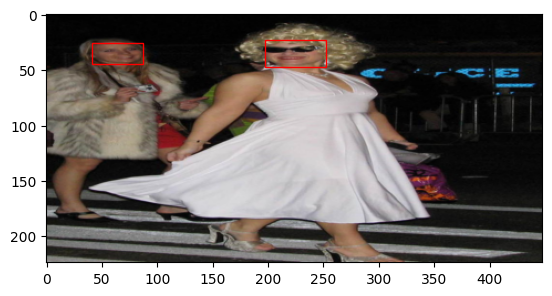

In [18]:
test_i = 14

_, ax = plt.subplots()

# plot image with bounding boxes
x, y = wider_face_dataset[test_i]
x = (x.permute(1, 2, 0) * 255).round().byte().numpy()

ax.imshow(x)

print(y["bboxes"], y["bboxValidity"])

for i, bbox in enumerate(y["bboxes"]):
    if not y["bboxValidity"][i]:
        continue
    
    x1, y1, x2, y2 = bbox * T.tensor(image_shape * 2)
    ax.add_patch(
        patches.Rectangle(
            (x1, y1), 
            x2 - x1, y2 - y1,
            linewidth=1, 
            edgecolor="red", 
            facecolor="none"))

plt.show()

# WFLW Face Recognition

In [19]:
import torch as T
import matplotlib.patches as patches
from matplotlib import pyplot as plt

from motion_capture.data.datasets import WFLWFaceDetection

image_shape = (224, 224)
wflw_dataset = WFLWFaceDetection(
    image_shape_WH=image_shape, 
    path="//192.168.2.206/data/datasets/WFLW/",
    max_number_of_faces=3
)

len(wflw_dataset)

6190

tensor([128.1875,  11.0040, 163.1875,  47.7847])
tensor([ 85.0938,  34.9717, 126.4375,  59.8439])


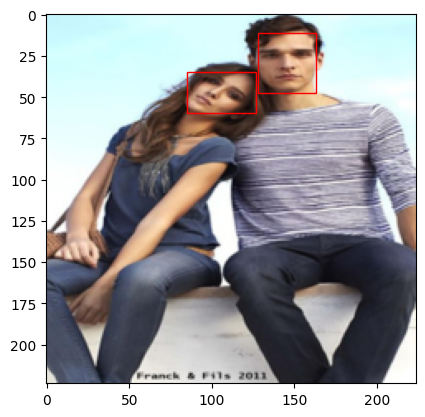

In [24]:
test_i = 1

x, y = wflw_dataset[test_i]

x = (x.permute(1, 2, 0) * 255).round().byte().numpy()

plt.imshow(x)

for i, bbox in enumerate(y["bboxes"]):
    if y["bboxValidity"][i] == 0:
        continue
    
    print(bbox * T.tensor(image_shape * 2))
    
    x1, y1, x2, y2 = bbox * T.tensor(image_shape * 2)
    plt.gca().add_patch(
        patches.Rectangle(
            (x1, y1), 
            x2 - x1, y2 - y1,
            linewidth=1, 
            edgecolor="red", 
            facecolor="none"))

plt.show()

# COFW Face Detection

In [1]:
import torch as T
from motion_capture.data.datasets import COFWFaceDetection
import matplotlib.pyplot as plt
from matplotlib import patches

image_shape = (224, 224)
cofw_color_dataset = COFWFaceDetection(
    path="//192.168.2.206/data/datasets/COFW/",
    image_shape_WH=image_shape)
len(cofw_color_dataset)

1852

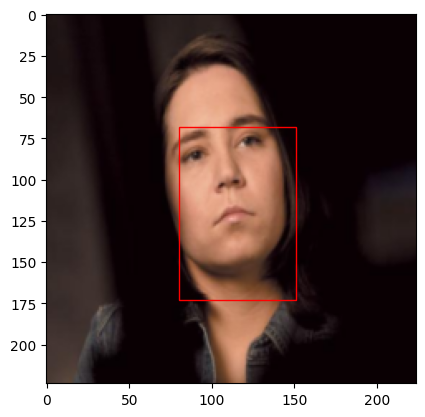

In [6]:
test_i = 115

x, y = cofw_color_dataset[test_i]

x = (x.permute(1, 2, 0) * 255).round().byte().numpy()

plt.imshow(x)

x1, y1, x2, y2 = y["bbox"] * T.tensor(image_shape * 2)
plt.gca().add_patch(
    patches.Rectangle(
        (x1, y1),
        x2 - x1, y2 - y1, 
        linewidth=1, 
        edgecolor="red", 
        facecolor="none"))


# COCO Global Person Instance Segmentation

In [1]:
import matplotlib.pyplot as plt
from matplotlib import patches
import torch as T

from motion_capture.data.datasets import COCO2017GlobalPersonInstanceSegmentation

image_shape = (448, 224)
person_instance_dataset = COCO2017GlobalPersonInstanceSegmentation(
    image_folder_path = "//192.168.2.206/data/datasets/COCO2017/images",
    annotation_folder_path = "//192.168.2.206/data/datasets/COCO2017/annotations",
    image_shape_WH=image_shape,
    max_num_persons=10,
    max_segmentation_points=100
)
len(person_instance_dataset)

56316

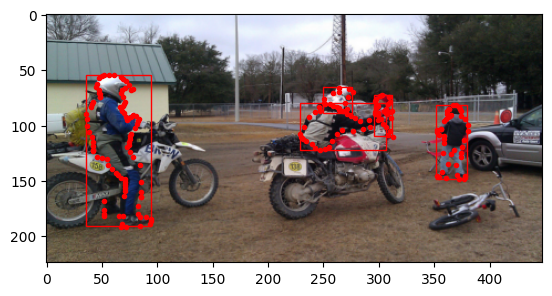

In [6]:
test_i = 124

x, y = person_instance_dataset[test_i]

plt.imshow((x.permute(1, 2, 0) * 255).round().byte().numpy())

for i, bbox in enumerate(y["bboxes"]):
    if y["bboxValidity"][i] == 0:
        continue
    
    x1, y1, x2, y2 = bbox * T.tensor(image_shape * 2)
    plt.gca().add_patch(
        patches.Rectangle(
            (x1, y1), 
            x2 - x1, y2 - y1,
            linewidth=1, 
            edgecolor="red", 
            facecolor="none"))

for i, segmentation in enumerate(y["segmentations"]):
    for j, point in enumerate(segmentation):
        if y["segmentationValidity"][i][j] == 0:
            continue
        
        x_, y_ = point * T.tensor(image_shape)
        plt.plot(x_, y_, color="red", marker=".")

plt.show()

# COCO Person Keypoints

In [1]:
from motion_capture.data.datasets import COCO2017PersonKeypointsDataset
import torch as T
import matplotlib.pyplot as plt
from matplotlib import patches

image_shape = (448, 224)
person_keypoints_dataset = COCO2017PersonKeypointsDataset(
    image_folder_path = "//192.168.2.206/data/datasets/COCO2017/images",
    annotation_folder_path = "//192.168.2.206/data/datasets/COCO2017/annotations",
    image_shape_WH = image_shape,
    min_person_bbox_size = 100
)
len(person_keypoints_dataset)

70563

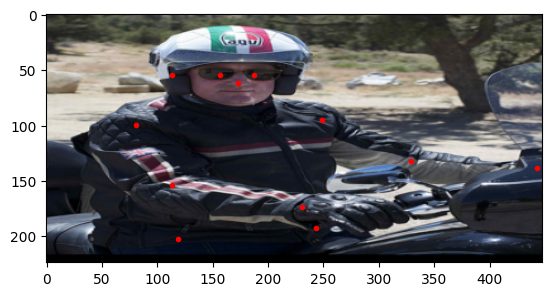

In [11]:
test_i = 9

x, y = person_keypoints_dataset[test_i]

plt.imshow((x.permute(1, 2, 0) * 255).round().byte().numpy())

for i, kpt in enumerate(y["keypoints"]):
    if not y["keypointValidity"][i]:
        continue
    
    x_, y_ = kpt * T.tensor(image_shape)
    plt.plot(x_, y_, color="red", marker=".")



plt.show()

# HAKE Large

In [1]:
from motion_capture.data.datasets import HAKELarge
import torch as T
import matplotlib.pyplot as plt
from matplotlib import patches

image_shape = (448, 224)
hake_dataset = HAKELarge(
    annotation_path = "\\\\192.168.2.206\\data\\datasets\\HAKE\\Annotations",
    image_path = "\\\\192.168.2.206\\data\\datasets\\HAKE-large",
    image_shape_WH = image_shape,
)
len(hake_dataset)


109337

In [18]:
datasets = {}
for k in hake_dataset.datapoints.keys():
    datasets[hake_dataset.datapoints[k]["dataset"]] = None
datasets

{'openimages': None,
 'hcvrd': None,
 'vcoco': None,
 'hico-det': None,
 'collect': None,
 'pic': None}

In [34]:
hake_dataset.datapoints["HICO_train2015_00000002.jpg"]

{'dataset': 'hico-det',
 'labels': [{'height': 480,
   'hoi_id': 224,
   'human_bbox': [262, 1, 638, 138],
   'object_bbox': [162, 131, 258, 165],
   'width': 640}],
 'path_prefix': 'hico_20160224_det/images/train2015'}

# MPII

In [6]:
from motion_capture.data.datasets import MPIIDataset

mpii_dataset = MPIIDataset(
    output_full_image_shape_WH=(448, 224),
    output_person_image_shape_WH=(224, 112),
    annotation_path="//192.168.2.206/data/datasets/MPII/annotations",
    image_folder_path="//192.168.2.206/data/datasets/MPII/images"
)
len(mpii_dataset)

29116

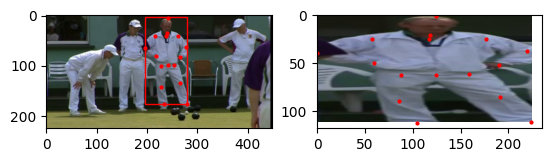

In [7]:
test_i = 110


_, ax = plt.subplots(1, 2)

# plot full image, keypoints, center and bounding box
ax[0].imshow(mpii_dataset[test_i]["fullImage"].permute(1,2,0).byte().numpy())

for dp in mpii_dataset[test_i]["globalKeypoints"]:
    ax[0].plot(dp[0], dp[1], "ro", markersize=2)

x, y = mpii_dataset[test_i]["personBbox"][0]
w, h = mpii_dataset[test_i]["personBbox"][1]
ax[0].add_patch(
    patches.Rectangle(
        (x-w, y-h), 
        w*2, h*2, 
        linewidth=1, 
        edgecolor="red", 
        facecolor="none"))

# plot person image and keypoints
ax[1].imshow(mpii_dataset[test_i]["personImage"].permute(1,2,0).byte().numpy())

for dp in mpii_dataset[test_i]["localKeypoints"]:
    ax[1].plot(dp[0], dp[1], "ro", markersize=2)

plt.show()

# COCO Panoptics Object Detection

In [1]:
from motion_capture.data.datasets import COCOPanopticsObjectDetection
import matplotlib.pyplot as plt
from matplotlib import patches
import torch as T

coco_panoptic_dataset = COCOPanopticsObjectDetection(
    image_folder_path = "//192.168.2.206/data/datasets/COCO2017/images",
    panoptics_path = "//192.168.2.206/data/datasets/COCO2017/panoptic_annotations_trainval2017/annotations",
    image_shape_WH=(224, 224),
    max_number_of_instances=10
)
len(coco_panoptic_dataset)

123287

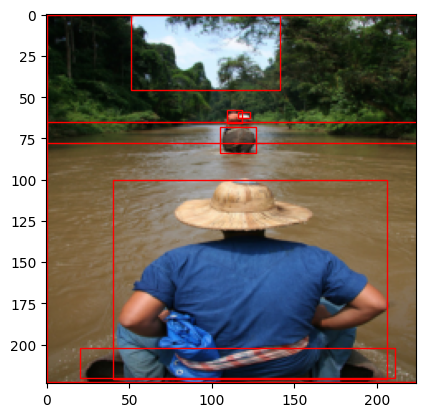

In [5]:
test_i = 1009

image = coco_panoptic_dataset[test_i][0]

_, ax = plt.subplots(1)

# plot full image and bounding box
ax.imshow(image.permute(1,2,0).byte().numpy())
for bbox in coco_panoptic_dataset[test_i][1]:
    x, y = bbox[0]
    w, h = bbox[1]
    ax.add_patch(
        patches.Rectangle(
            (x-w, y-h), 
            w*2, h*2, 
            linewidth=1, 
            edgecolor="red", 
            facecolor="none"))

plt.show()

# COCO Captions

In [8]:
class COCO2017CaptionsDataset(data.Dataset):
    
    def __init__(
        self,
        image_folder_path: str,
        annotation_folder_path: str):
        
        super().__init__()
        
        self.image_folder_path = image_folder_path
        self.annotation_path = annotation_folder_path
        
        with open(os.path.join(annotation_folder_path, "captions_train2017.json"), "r") as f:
            self.train_datapoints = json.load(f)
            
        with open(os.path.join(annotation_folder_path, "captions_val2017.json"), "r") as f:
            self.val_datapoints = json.load(f)
            
    def __len__(self):
        return len(self.all_datapoints)
    
    def __getitem__(self, idx):
        return self.all_datapoints[idx]

# COCO Person Keypoints

In [13]:
from motion_capture.data.datasets import COCO2017PersonKeypointsDataset

coco_dataset = COCO2017PersonKeypointsDataset(
    image_folder_path="//192.168.2.206/data/datasets/COCO2017/images",
    annotation_folder_path="//192.168.2.206/data/datasets/COCO2017/annotations",
    output_full_image_shape_WH=(448, 224),
    output_person_image_shape_WH=(224, 112),
    load_val_only=False
)
len(coco_dataset)

38840

1


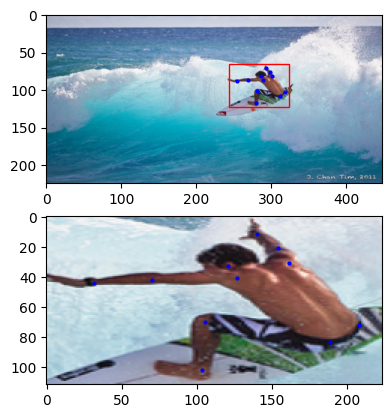

In [7]:
test_i = 20000

full_image = coco_dataset[test_i]["fullImage"].permute(1, 2, 0).round().byte().numpy()

num_persons = coco_dataset[test_i]["personImages"].shape[0]

print(num_persons)

# create plot scale it to number of persons
fig, ax = plt.subplots(num_persons + 1)
# fig.set_size_inches(10, 10 * (num_persons + 1))


ax[0].imshow(full_image)

for i in range(num_persons):
    
    # keypoints, bounding box and segmentation in full image
    kpts = coco_dataset[test_i]["globalKeypoints"][i]
    vis = coco_dataset[test_i]["keypointVisibility"][i]
    val = coco_dataset[test_i]["keypointValidity"][i]
    
    for j in range(kpts.shape[0]):
        if vis[j]:
            ax[0].plot(kpts[j][0], kpts[j][1], "bo", markersize=2)
        elif val[j]:
            ax[0].plot(kpts[j][0], kpts[j][1], "ro", markersize=2)
    
    x, y = coco_dataset[test_i]["personBboxes"][i][0]
    w, h = coco_dataset[test_i]["personBboxes"][i][1]
    ax[0].add_patch(
        patches.Rectangle(
            (x-w, y-h), 
            w*2, h*2, 
            linewidth=1, 
            edgecolor="red", 
            facecolor="none"))

    # plot individual person image and keypoints
    person_image = coco_dataset[test_i]["personImages"][i].permute(1, 2, 0).round().byte().numpy()
    ax[i+1].imshow(person_image)
    
    kpts = coco_dataset[test_i]["localKeypoints"][i]
    vis = coco_dataset[test_i]["keypointVisibility"][i]
    val = coco_dataset[test_i]["keypointValidity"][i]
    for j in range(kpts.shape[0]):
        if vis[j]:
            ax[i+1].plot(kpts[j][0], kpts[j][1], "bo", markersize=2)
        elif val[j]:
            ax[i+1].plot(kpts[j][0], kpts[j][1], "ro", markersize=2)

plt.show()


# COCO Whole Body

In [15]:
from motion_capture.data.datasets import COCO2017WholeBodyDataset

coco_wholebody_dataset = COCO2017WholeBodyDataset(
    annotations_folder_path="//192.168.2.206/data/datasets/COCO2017/annotations",
    image_folder_path="//192.168.2.206/data/datasets/COCO2017/images",
    full_image_shape_WH=(448, 448),
    person_image_shape_WH=(224, 224),
    bodypart_image_shape_WH=(112, 112),
    load_val_only=False)
len(coco_wholebody_dataset)

70563

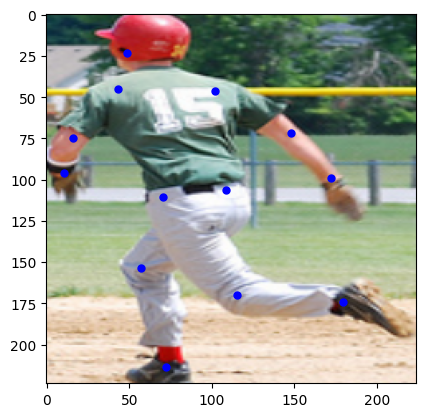

In [27]:
test_i = 10108


_, ax = plt.subplots(1)

# plot person image
ax.imshow(coco_wholebody_dataset[test_i]["personImages"].permute(1, 2, 0).byte().numpy())

# plot keypoints
kpts = coco_wholebody_dataset[test_i]["keypoints"]
vis = coco_wholebody_dataset[test_i]["keypointsVisibility"]
val = coco_wholebody_dataset[test_i]["keyponitsValidity"]
for j in range(kpts.shape[0]):
    if vis[j]:
        ax.plot(kpts[j][0], kpts[j][1], "bo", markersize=5)
    elif val[j]:
        ax.plot(kpts[j][0], kpts[j][1], "ro", markersize=5)

# plot bounding boxes
bboxes = [
    coco_wholebody_dataset[test_i]["faceBbox"],
    coco_wholebody_dataset[test_i]["leftHandBbox"],
    coco_wholebody_dataset[test_i]["rightHandBbox"]
]

for bbox in bboxes:
    x, y = bbox[0]
    w, h = bbox[1]
    ax.add_patch(
        patches.Rectangle(
            (x-w, y-h), 
            w*2, h*2, 
            linewidth=1, 
            edgecolor="red", 
            facecolor="none"))



plt.show()

# HAKE Large

# hico_det

In [ ]:
# hd = scipy.io.loadmat("./../_data/_usefull/_images/Halpe-FullBody/hico_det/anno.mat")
# hd_bb = scipy.io.loadmat("./../_data/_usefull/_images/Halpe-FullBody/hico_det/anno_bbox.mat")

# """

# len(hd_bb["bbox_train"][0][i][1][0]) = 1

# len(hd_bb["bbox_train"][0][i][0]) = 1
# (name)


# """

In [ ]:
# hd_bb.keys()

In [ ]:
# print(len(hd["list_train"]), len(hd["list_test"]))

# hd_bb["bbox_train"][0][0][0]
# hd_bb["bbox_train"][0][0][1]

# for i in range(len(hd_bb["bbox_train"][0])):
#     image_name = hd_bb["bbox_train"][0][i][0][0]

#     width, height, depth = hd_bb["bbox_train"][0][i][1][0][0]
#     width, height, depth = width[0][0], height[0][0], depth[0][0]


# sum([len(hd_bb["bbox_train"][0][i][2][0]) for i in range(len(hd_bb["bbox_train"][0]))])

# [b[1] for b in hd_bb["bbox_train"][0][0][2][0]]




# RHDv2

In [ ]:
# arr = pickle.load(open("./../_data/_usefull/_images/RHD_published_v2/training/anno_training.pickle", "br"))

"""

arr[i]["xyz"] = xyz keypoints
arr[i]["uv_vis] = uv + visibility
arr[i]["K"] = camera
(i == image)


"""
None

# HAKE

In [ ]:
# hake_large_annotation = json.load(open("./../_data/_usefull/_images/HAKE/Annotations/hake_large_annotation.json", "r"))
# hico_det_training_set_instance_level = json.load(open("./../_data/_usefull/_images/HAKE/Annotations/hico-det-training-set-instance-level.json", "r"))
# hico_training_set_image_level = json.load(open("./../_data/_usefull/_images/HAKE/Annotations/hico-training-set-image-level.json", "r"))

"""

hico training set image level

{'arm_list': [0, 0, 0, 0, 1], 
'foot_list': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
'hand_list': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
'head_list': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 
'hip_list': [1, 0, 0, 0, 0], 
'hoi_id': [153, 154, 155, 156], 
'leg_list': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 
'parts_list': [1, 1, 1, 1, 1, 0, 1, 0, 0, 1]}


hico det training set instance level

{'dataset': 'hico-det', 
'labels': [
    {
        'action_labels': 
            [{'human_part': 6, 'partstate': 0}, 
            {'human_part': 9, 'partstate': 0}, 
            {'human_part': 4, 'partstate': 0}, 
            {'human_part': 0, 'partstate': 0}, 
            {'human_part': 3, 'partstate': 0}], 
        'height': 480, 
        'hoi_id': 153, 
        'human_bbox': [208, 33, 427, 300], 
        'object_bbox': [59, 98, 572, 405], 
        'width': 640
    }, 
    {
        'action_labels': 
            [{'human_part': 4, 'partstate': 0}, 
            {'human_part': 1, 'partstate': 6}, 
            {'human_part': 2, 'partstate': 6}], 
        'height': 480, 
        'hoi_id': 156, 
        'human_bbox': [209, 26, 444, 317], 
        'object_bbox': [59, 99, 579, 395], 
        'width': 640
    },
        ...], 
'path_prefix': 'hico_20160224_det/images/train2015'}



hake large annotation

{'dataset': 'hico-det', 
'labels': [
    {'action_labels': 
        [{'human_part': 6, 'partstate': 0}, {'human_part': 9, 'partstate': 0}, {'human_part': 4, 'partstate': 0}, {'human_part': 0, 'partstate': 0}, {'human_part': 3, 'partstate': 0}], 'height': 480, 'hoi_id': 153, 'human_bbox': [208, 33, 427, 300], 'object_bbox': [59, 98, 572, 405], 'width': 640}, 
    {'action_labels': 
        [{'human_part': 4, 'partstate': 0}, {'human_part': 1, 'partstate': 6}, {'human_part': 2, 'partstate': 6}], 'height': 480, 'hoi_id': 156, 'human_bbox': [209, 26, 444, 317], 'object_bbox': [59, 99, 579, 395], 'width': 640}, 
    {'action_labels': 
        [{'human_part': 6, 'partstate': 0}, {'human_part': 9, 'partstate': 0}, {'human_part': 4, 'partstate': 0}, {'human_part': 0, 'partstate': 0}, {'human_part': 3, 'partstate': 0}], 'height': 480, 'hoi_id': 154, 'human_bbox': [213, 20, 438, 357], 'object_bbox': [77, 115, 583, 396], 'width': 640}, {'action_labels': [{'human_part': 4, 'partstate': 0}], 'height': 480, 'hoi_id': 155, 'human_bbox': [206, 33, 427, 306], 'object_bbox': [61, 100, 571, 401], 'width': 640}], 
    ...
    
'path_prefix': 'hico_20160224_det/images/train2015'}


"""
None

# FreiHAND

In [ ]:
"""
training_K = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_K.json", "r"))
training_mano = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_mano.json", "r"))
training_scale = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_scale.json", "r"))
training_verts = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_verts.json", "r"))
training_xyz = json.load(open("./../_data/_usefull/FreiHAND/FreiHAND_pub_v2/training_xyz.json", "r"))

# length is the same for all = 32560 = number of greenscreened images

K = intrinsic camera matrix
mano = mano annotations ?
verts = 3d vertecies
xyz = 3d shape
"""

# Kinect

In [ ]:
# info = json.load(open("./../_data/_usefull/KinectDatasets/data/training/info.json", "r"))
# calib = json.load(open("./../_data/_usefull/KinectDatasets/data/training/calib.json", "r"))
# anno = json.load(open("./../_data/_usefull/KinectDatasets/data/training/anno.json", "r"))
# pred_sdk = json.load(open("./../_data/_usefull/KinectDatasets/data/training/pred_sdk.json", "r"))

# captury_info = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/info.json", "r"))
# captury_calib = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/calib.json", "r"))
# captury_anno = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/anno.json", "r"))
# captury_pred_sdk = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/pred_sdk.json", "r"))
# captury_pred_sdk_cap = json.load(open("./../_data/_usefull/KinectDatasets/data/captury_train/pred_sdk_cap.json", "r"))

"""
1920x1080

anno[0][0] = 18 kpts + vis

pred_sdk[0][i] = 25 kpts + vis (is a prediction)
(i == 4 for all)


captury_pred_sdk[0][i] = 25 kpts + vis
(i == 1 for all)

captury_pred_sdk_cap[0][i] = 25 kpts + vis
(i == 2 for all)


"""
None